### Цель работы:
Сравнить различные показатели наиболее экономически успешных стран.
### Задачи:
- Загрузить данные с открытого хранилища данных World Data Bank
- Отобрать подходящие страны

In [77]:
import requests
import json
import pandas as pd
import os.path

# data have many ';' and ','
csv_delimiter = '::'
# indicators to analysis
indicators = [
    'SP.DYN.CDRT.IN',   # Death rate
    'NY.GDP.MKTP.CD',   # GDP (current $)
    'NY.GDP.PCAP.KD',   # GDP per capita (constant 2015 $)
]

def download_json(url: str, filepath: str):
    """Download json from url and return result"""
    dataset_request = requests.get(
        url,
        stream=True,
    )
    # write bytes to file
    with open(filepath, "wb") as file:
        for chunk in dataset_request.iter_content(chunk_size=128):
            file.write(chunk)
    # read downloaded json
    with open(filepath, "rt") as file:
        res = json.load(file)
    return res


def download_indicators_list():
    """Get full list of indicators from specified datasets and write to inticators.csv"""
    datasets_ids = [
        "0037712",  # World Development Indicators
        "0037798",  # Global Economical Monitor
    ]
    with open('indicators.csv', 'wt') as indicators_file:
        print("name", "id", "load", sep=csv_delimiter, file=indicators_file)
        for dataset_unique_id in datasets_ids:
            # get dataset info
            dataset_url = f"https://datacatalogapi.worldbank.org/ddhxext/DatasetView?dataset_unique_id={dataset_unique_id}"
            dataset_metadata_path = f"datasets_metadata/{dataset_unique_id}.json"
            indicators = download_json(dataset_url, dataset_metadata_path)
            # get data for each indicator
            for indicator in indicators["Indicator"]:
                # parse url to get values
                name = indicator.split("::")[0]
                id = indicator.split("=")[-1]
                load = 0
                print(name, id, load, sep=csv_delimiter, file=indicators_file)


def get_indicators_data(indicators=None):
    """Download indicators from DataBank. If not specified based on settings from indicators.csv)"""
    all_indicators = pd.read_csv("indicators.csv", delimiter=csv_delimiter, engine='python')
    if indicators:
        needed_indicators = indicators
    else:
        needed_indicators = all_indicators[all_indicators["load"] == 1]['id']
    df = pd.DataFrame(columns=['country', 'date'])
    for id in needed_indicators:
        json_path = f"indicators/json/{id}.json"
        csv_path = f"indicators/csv/{id}.csv"
        # skip already loaded indicators
        if os.path.exists(csv_path):
            print(id, "is already loaded")
        else:
            url = f"https://api.worldbank.org/v2/country/all/indicator/{id}?per_page=20000&format=json"
            print("Downloading", id)
            data = download_json(url, json_path)
            # check if got valid data
            if len(data) != 2:
                print(f"Not found {id}")
                continue
            # convert raw json data to csv
            with open(csv_path, 'wt') as csv_file:
                name = data[1][0]["indicator"]["value"]
                print('country', 'date', name, sep=csv_delimiter, file=csv_file)
                for row in data[1]:
                    country = row["country"]["value"]
                    date = row["date"]
                    value = row["value"]
                    print(country, date, value, sep=csv_delimiter, file=csv_file)
        
        # read downloaded csv
        new = pd.read_csv(csv_path, delimiter=csv_delimiter, engine='python')
        # drop empty rows
        new.dropna(how='any', inplace=True)
        # merge with main dataset
        df = pd.merge(left=df, right=new, how='outer', on=('country', 'date'))

    return df

In [78]:
# download_indicators_list()


In [79]:
df = get_indicators_data(indicators)

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16705 entries, 0 to 16704
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   country                               16705 non-null  object 
 1   date                                  16705 non-null  int64  
 2   Death rate, crude (per 1,000 people)  16282 non-null  float64
 3   GDP (current US$)                     13979 non-null  float64
 4   GDP per capita (constant 2015 US$)    13963 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 652.7+ KB


In [81]:
r = df[df['country'] == 'Russian Federation']

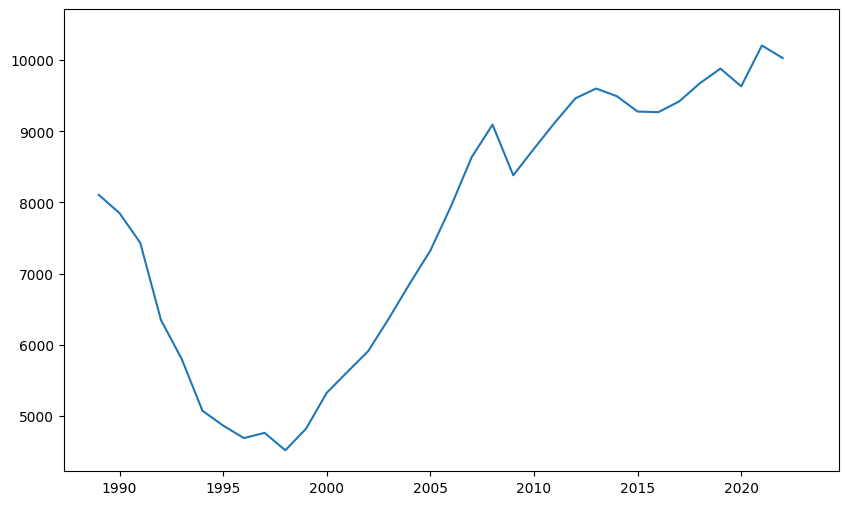

In [82]:
import matplotlib.pyplot as plt

plt.figure('1', figsize=(10, 6))

plt.subplot(1, 1, 1)
plt.plot(r['date'], r['GDP per capita (constant 2015 US$)'])